<a href="https://colab.research.google.com/github/LeszekBlazewski/MTSwM/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temat: Komputerowe wspomaganie diagnozowania zawałów z wykorzystaniem algorytmu k-NN.

# Opis problemu medycznego jako zadania klasyfikacji wraz z identyfikacją klas oraz cech

Zadanie klasyfikacji w projekcie polega na wspomożeniu rozpoznania stanów zawałowych wśród pacjentów na podstawie danych zebranych podczas badań na osobach u których potwierdzono jedną z poniższych diagnoz:


1.   Ból nie pochodzący z organu serca - inne.txt
2.   Dusznica bolesna (dławica piersiowa) - ang_prect.txt
3.   Dusznica Prinzmetala (dławica naczynioskurczowa) - ang_prct_2.txt
4.   Pełnościenny zawał serca - mi.txt
5.   Podwsierdziowy zawał serca - mi_np.txt

Wynikiem zadania klasyfikacji jest przydzielenie, każdego z pacjentów do jednej z powyższych klas. Klasom przydzieliliśmy odpowiednią numerację zgodną z wypunktowaniem powyżej.

---

Większość z zawartych cech w danych ma charakter dyskretny, natomiast te które w rzeczywistości są ciągłe zostały zdyskretyzowane za pomocą odpowiednich przedziałów jak np. czas trwania ostatniego bólu:


1.   krócej niż 5 minut
2.   od 5 do 30 minut
3.   od 30 do 60 minut
4.   od 1 do 6 godzin
5.   od 6 do 12 godzin
6.   dłużej niż 12 godzin

---

##Liczba klas: 5

##Liczba cech: 59



# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%cd /content/gdrive/My Drive/Colab Notebooks/MTSwM

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/MTSwM


# Dataset features

In [2]:
dataset_features_columns = [
    'Age',
    'Sex',
    # Pain
    'Pain location', 
    'Chest pain radiation', 
    'Pain character', 
    'Onset of pain', 
    'Number of hours since onset', 
    'Duration of the last episode', 
    # Associated symptoms
    'Nausea', 
    'Diaphoresis',
    'Palpitations',
    'Dyspnea',
    'Dizziness/syncope',
    'Burping',
    # Palliative factors
    'Palliative factors',
    # History of similar pain
    'Prior chest pain of this type',
    'Physician consulted for prior pain',
    'Prior pain related to heart',
    'Prior pain due to MI',
    'Prior pain due to angina prectoris',
    # Past medical history
    'Prior MI',
    'Prior angina prectoris',
    'Prior atypical chest pain',
    'Congestive heart failure',
    'Peripheral vascular disease',
    'Hiatal hernia',
    'Hypertension',
    'Diabetes',
    'Smoker',
    # Current medication usage
    'Diuretics',
    'Nitrates',
    'Beta blockers',
    'Digitalis',
    'Nonsteroidal anti-inflammator',
    'Antacids/H2 blockers',
    # Physical examinations
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Heart rate',
    'Respiration rate',
    'Rales',
    'Cyanosis',
    'Pallor',
    'Systolic murmur',
    'Diastolic murmur',
    'Oedema',
    'S3 gallop',
    'S4 gallop',
    'Chest wall tenderness',
    'Diaphoresis',
    # ECG examination
    'New Q wave',
    'Any Q wave',
    'New ST segment elevation',
    'Any ST segment elevation',
    'New ST segment depression',
    'Any ST segment depression',
    'New T wave inversion',
    'Any T wave inversion',
    'New intraventricular conduction defect',
    'Any intraventricular conduction defect',
    'Class'
]

# Load & merge datasets

In [3]:
data_list = []

for i, file in enumerate(glob.glob("data/*.txt"), 1):
  data_set = pd.read_csv(file,sep="\t", header=None).transpose()
  data_set['Class'] = i
  data_list.append(data_set)

dataset = pd.concat(data_list, axis=0)

dataset.columns = dataset_features_columns

dataset.info()
#dataset.head()
#dataset.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 67
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     901 non-null    int64
 1   Sex                                     901 non-null    int64
 2   Pain location                           901 non-null    int64
 3   Chest pain radiation                    901 non-null    int64
 4   Pain character                          901 non-null    int64
 5   Onset of pain                           901 non-null    int64
 6   Number of hours since onset             901 non-null    int64
 7   Duration of the last episode            901 non-null    int64
 8   Nausea                                  901 non-null    int64
 9   Diaphoresis                             901 non-null    int64
 10  Palpitations                            901 non-null    int64
 11  Dyspnea             

# Feature ranking

## SelectKBest

In [4]:
def build_features_ranking(x, y, score_func):
    features_num = x.shape[1]
    k_best_selector = SelectKBest(score_func=score_func, k=features_num) 
    k_best_selector.fit(x, y)
    scores_ranking = [
        (name, round(score, 2))
        for name, score in zip(x.columns, k_best_selector.scores_)
    ]
    scores_ranking.sort(reverse=True, key=lambda x: x[1])
    return scores_ranking

In [5]:
def print_features_ranking_with_plot(features_ranking, used_score_func):
  print(f'Features ranking after using {used_score_func} score function:')
  for i, feature in enumerate(features_ranking, 1):
    print(f"{i}. {feature[0]} {feature[1]}")
  # display bar plot
  plt.figure(figsize=(30,20))
  estimator_num = len(features_ranking)
  # sort ascending because horizontal bars print in reverse order
  ascending_features = sorted([(f[0], f[1]) for f in features_ranking], key=lambda f: f[1])
  plt.barh(range(estimator_num), [feature[1] for feature in ascending_features], align='center') # extract score value
  plt.yticks(range(estimator_num), [feature[0] for feature in ascending_features]) # extract the feature label
  plt.title(f'Ranking based on {used_score_func}')
  plt.show()

Features ranking after using f_classif score function:
1. New ST segment depression 304.24
2. New ST segment elevation 237.16
3. New Q wave 229.16
4. Any ST segment depression 205.43
5. New T wave inversion 180.8
6. Systolic blood pressure 146.52
7. New intraventricular conduction defect 132.6
8. Any T wave inversion 114.27
9. Number of hours since onset 95.74
10. Prior pain related to heart 91.66
11. Pain location 90.97
12. Any Q wave 90.55
13. Respiration rate 89.65
14. Any intraventricular conduction defect 87.17
15. S3 gallop 83.8
16. Palpitations 74.79
17. Diastolic murmur 74.17
18. Prior angina prectoris 71.71
19. Dizziness/syncope 55.57
20. Congestive heart failure 55.24
21. Any ST segment elevation 52.26
22. S4 gallop 51.23
23. Hiatal hernia 49.76
24. Prior atypical chest pain 47.42
25. Systolic murmur 47.26
26. Prior pain due to angina prectoris 45.89
27. Chest wall tenderness 42.72
28. Nitrates 40.13
29. Burping 36.7
30. Prior pain due to MI 36.53
31. Rales 36.47
32. Antacids

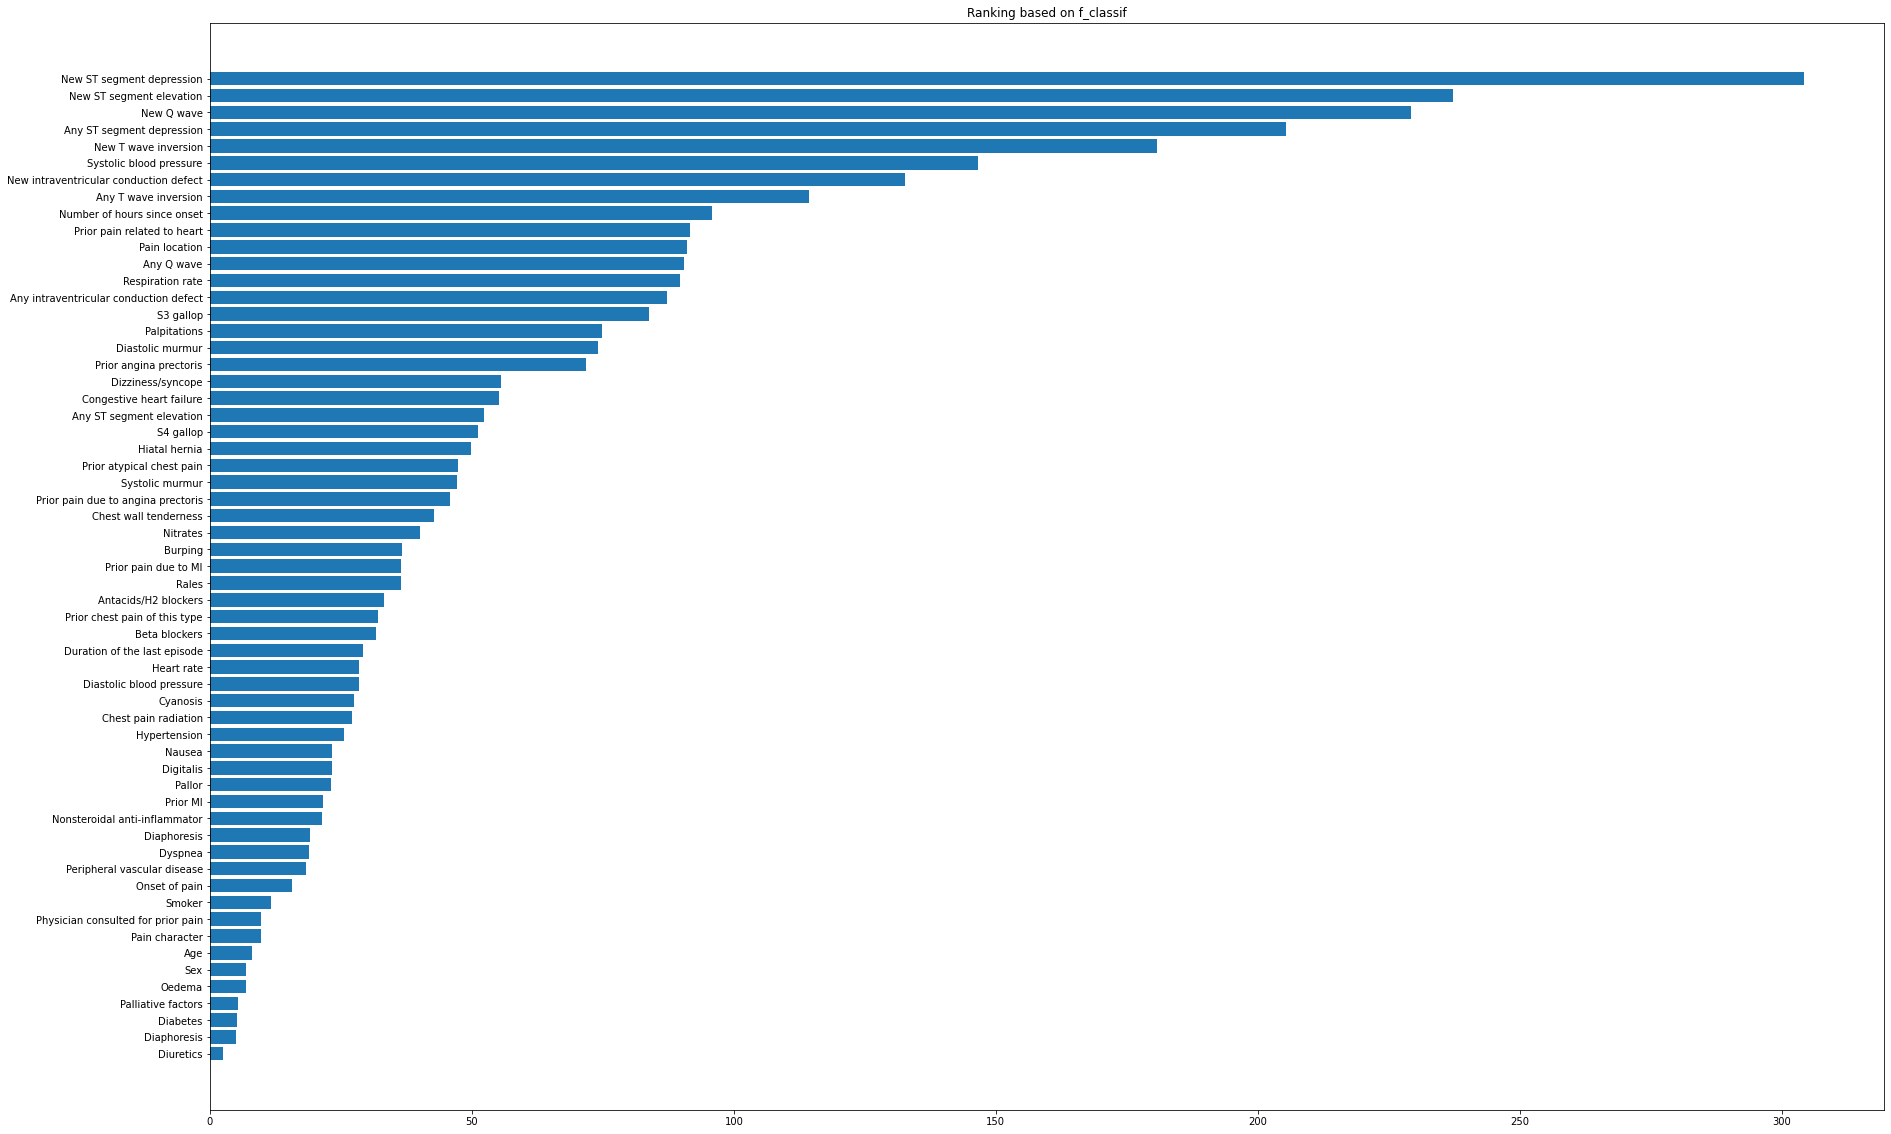

Features ranking after using chi2 score function:
1. Systolic blood pressure 1980.23
2. Number of hours since onset 978.58
3. Pain location 340.52
4. New ST segment depression 223.47
5. New Q wave 200.26
6. New T wave inversion 193.4
7. New ST segment elevation 188.22
8. Any ST segment depression 177.0
9. New intraventricular conduction defect 159.89
10. Any T wave inversion 151.67
11. Respiration rate 120.3
12. Diastolic murmur 117.16
13. Any intraventricular conduction defect 117.1
14. Prior angina prectoris 116.64
15. Chest pain radiation 114.72
16. Heart rate 109.56
17. Any Q wave 108.82
18. S3 gallop 105.09
19. Prior pain related to heart 101.63
20. Prior pain due to MI 89.17
21. S4 gallop 87.11
22. Prior pain due to angina prectoris 85.87
23. Congestive heart failure 85.27
24. Systolic murmur 84.5
25. Hiatal hernia 83.61
26. Dizziness/syncope 83.29
27. Palpitations 82.35
28. Beta blockers 79.73
29. Diastolic blood pressure 78.56
30. Nitrates 76.57
31. Any ST segment elevation 75.

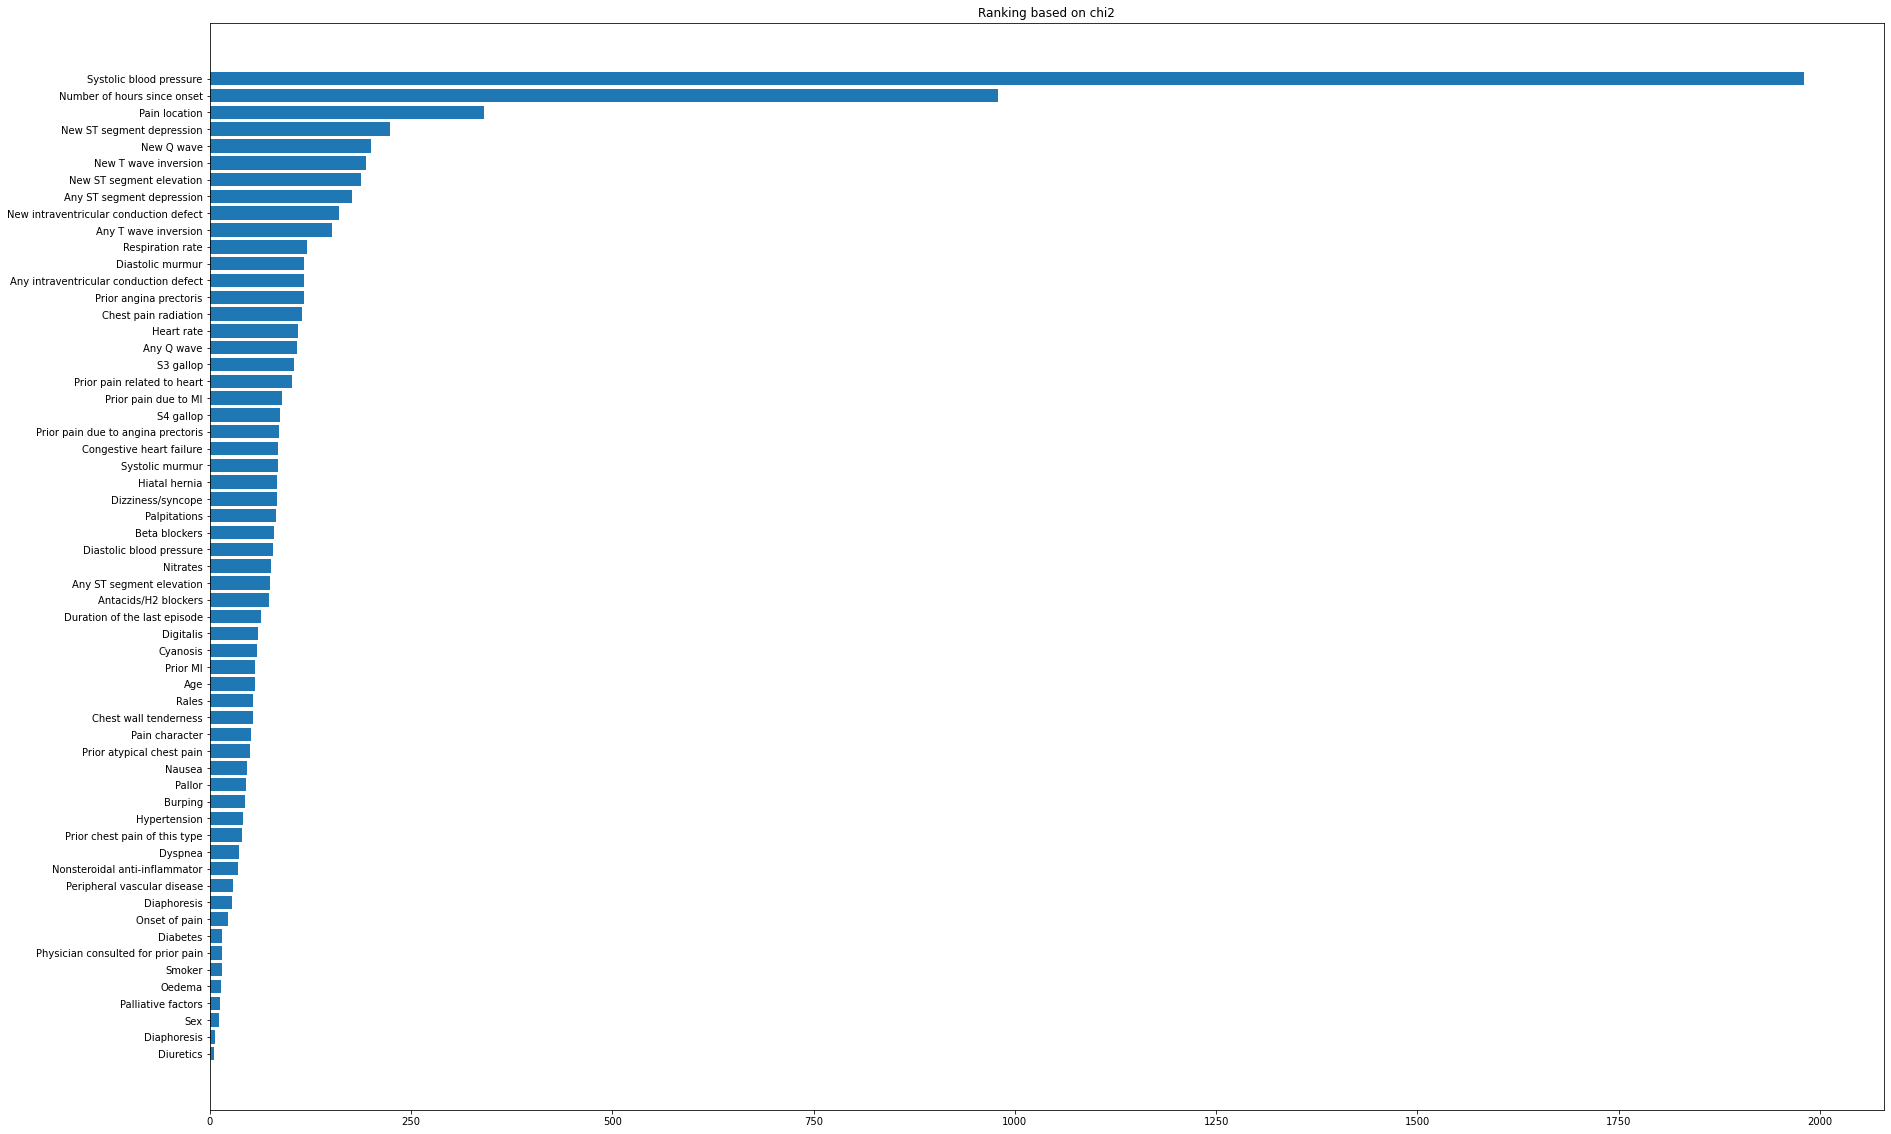

In [6]:
x = dataset.drop('Class', axis=1)
y = dataset['Class']
# f_classif: ANOVA test (F-value between label/feature for regression tasks)
features_ranking_classif = build_features_ranking(x, y, f_classif)
print_features_ranking_with_plot(features_ranking_classif, 'f_classif')
# chi-squared stats of non-negative features for classification tasks.
features_ranking_chi = build_features_ranking(x, y, chi2)
print_features_ranking_with_plot(features_ranking_chi, 'chi2')

## Pearson correlation

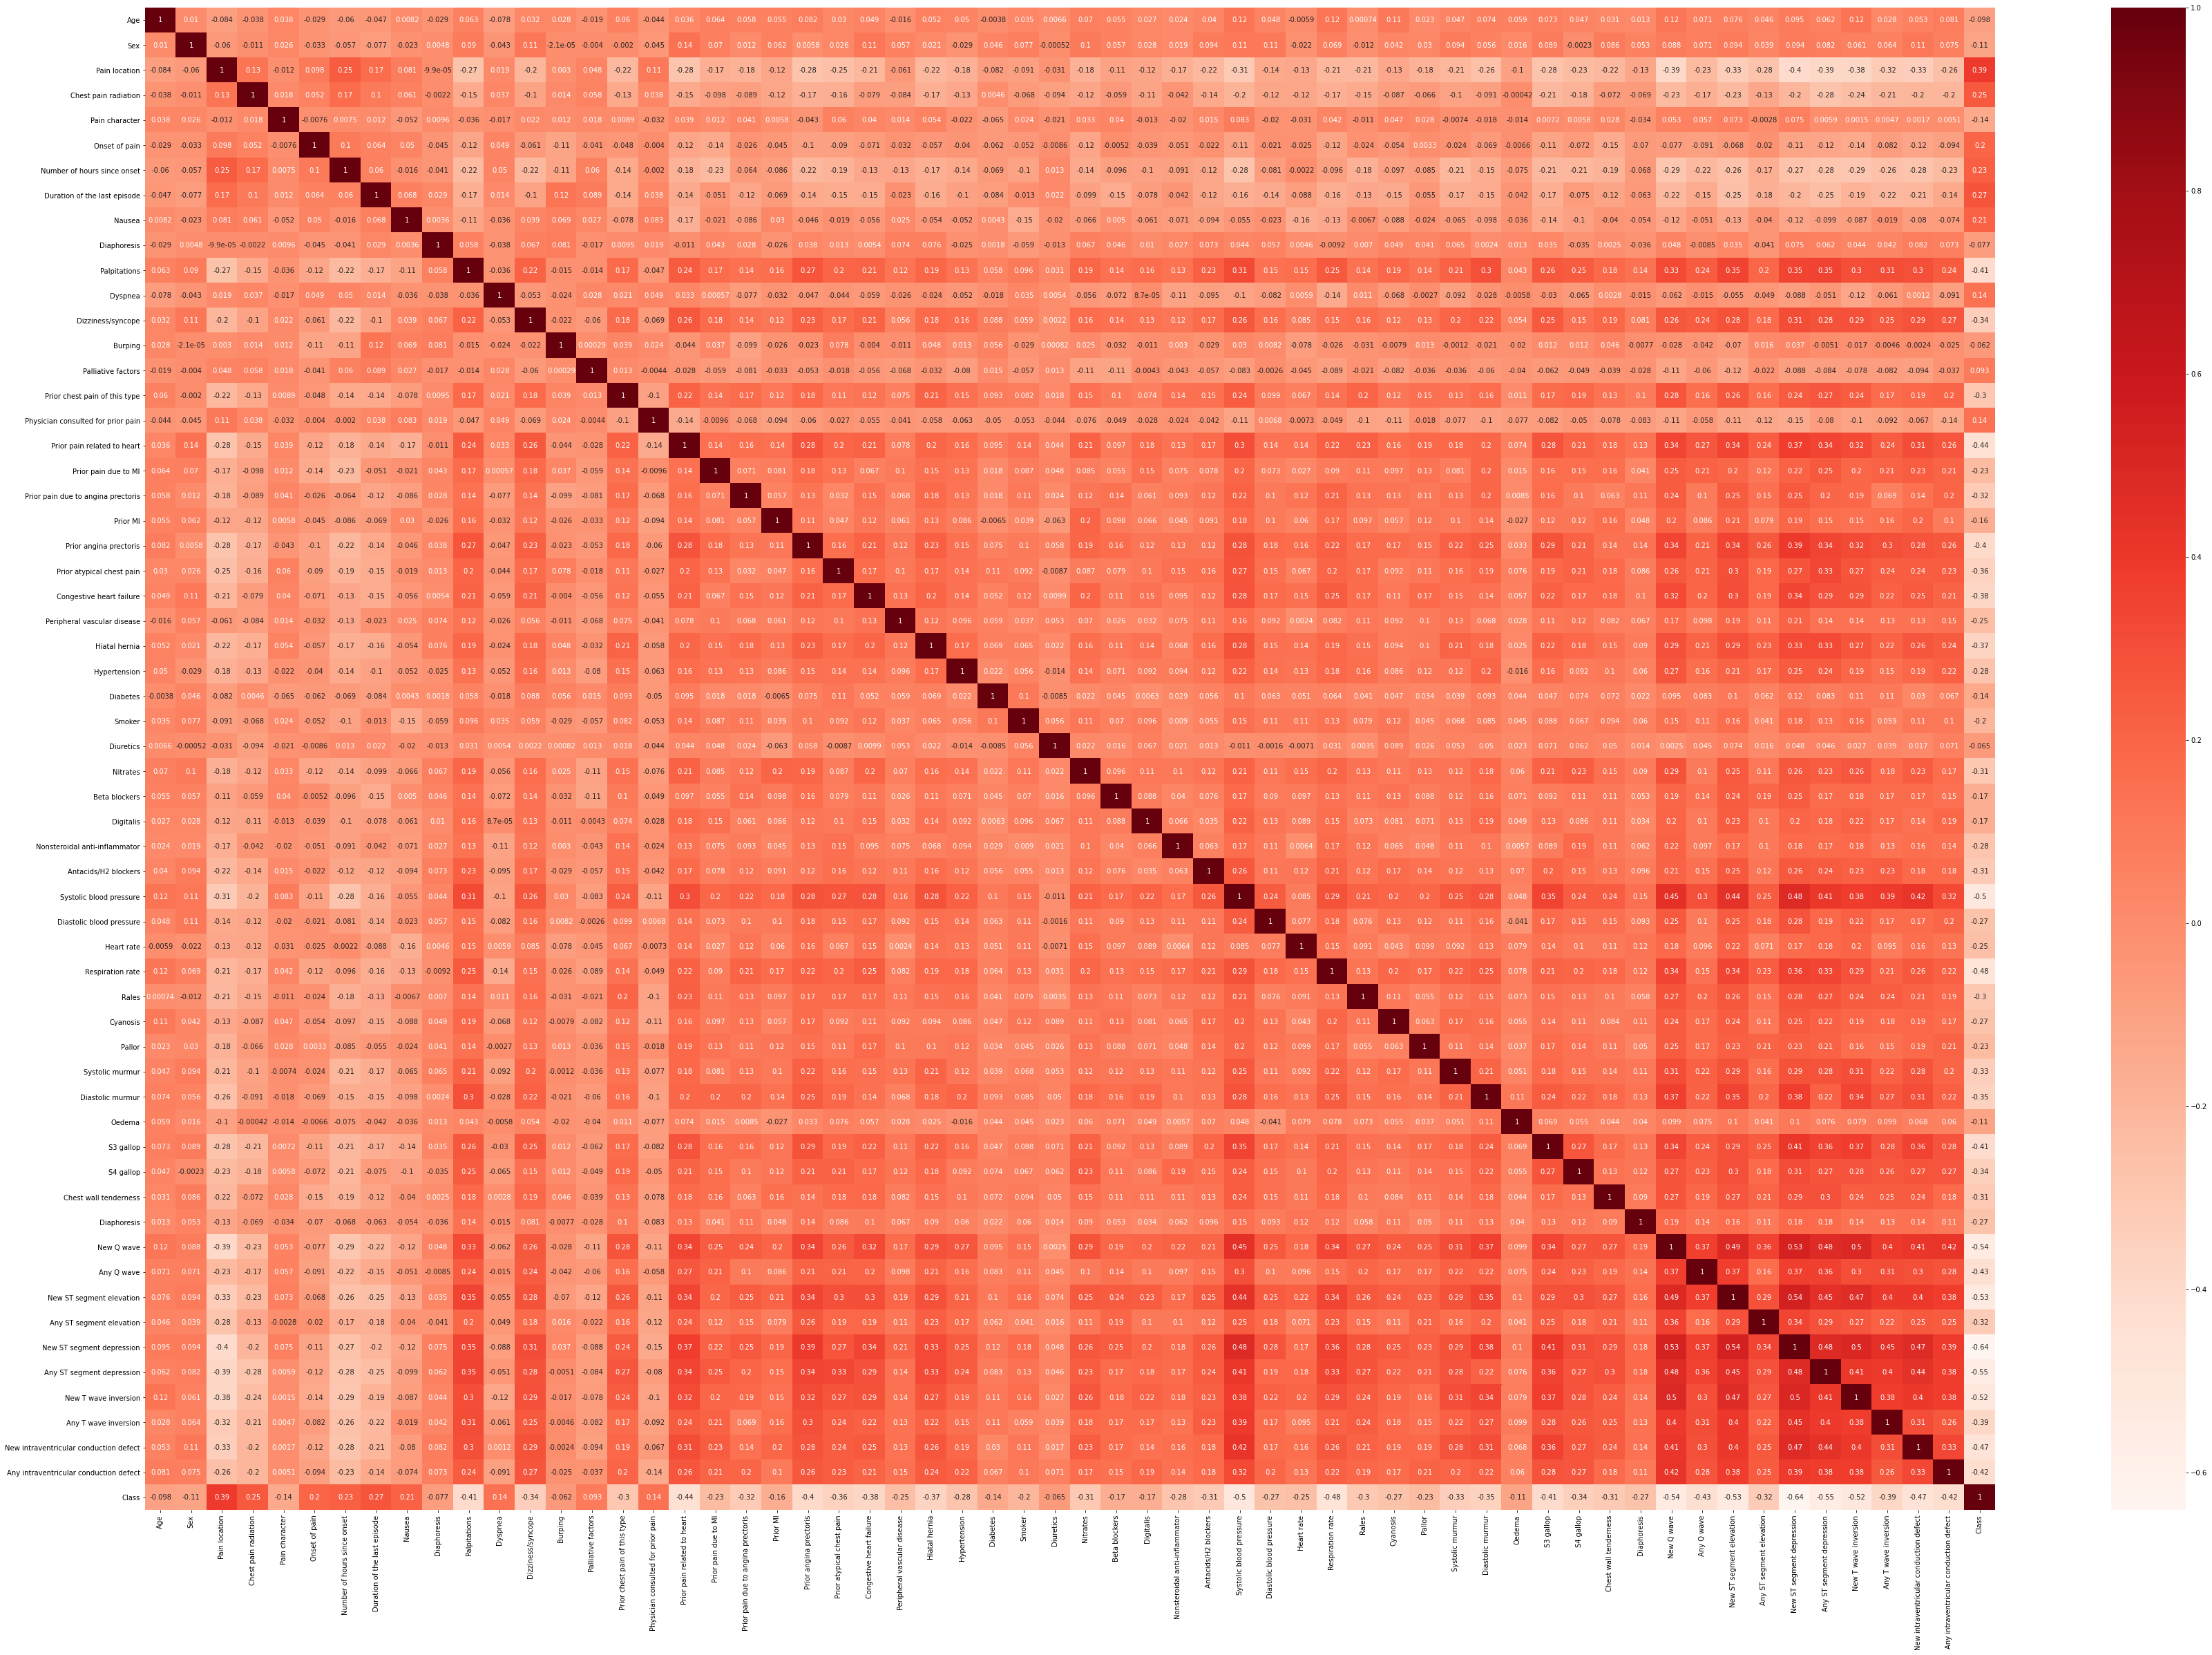

In [7]:
plt.figure(figsize=(60,40))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Systolic blood pressure      0.502009
New Q wave                   0.538592
New ST segment elevation     0.530536
New ST segment depression    0.640865
Any ST segment depression    0.553203
New T wave inversion         0.515912
Class                        1.000000
Name: Class, dtype: float64